In [1]:
%matplotlib inline

In [2]:
from pycaret.regression import RegressionExperiment
import pickle
import json
import pandas as pd

In [3]:
# Load data
current_time = "2024-11-25T05:57Z"
n_qubits = 4
backend_qpu_name = "ibm_marrakesh"
graph_type = "line"
path = f"./data/{current_time}_{n_qubits}_{backend_qpu_name}_{graph_type}"

data_exact_df = pd.read_json(f"{path}/data_exact_df.json")
data_sim_df = pd.read_json(f"{path}/data_sim_df.json")
data_sim_noisy_df = pd.read_json(f"{path}/data_sim_noisy_df.json")
data_nmit_df = pd.read_json(f"{path}/data_qpu_nmit_df.json")
data_mit_df = pd.read_json(f"{path}/data_qpu_mit_df.json")

with open(f"{path}/params.pkl", "rb") as f:
    params = pickle.load(f)

for key, value in params.items():
    print(f"{key}: {value}")

n_samples: 20
n_qubits: 4
backend_qpu_name: ibm_marrakesh
beta: 1
C: 24
n_features: 5
times: [0.0, 0.2617993877991494, 0.5235987755982988, 0.7853981633974483, 1.0471975511965976]
Js: [list([0.3947360581187278, -0.8116453042247009, 0.9512447032735118])
 list([0.5222794039807059, 0.5721286105539076, -0.7437727346489083])
 list([-0.09922812420886573, -0.25840395153483753, 0.8535299776972036])
 list([0.2877302401613291, 0.64552322654166, -0.11317160234533774])
 list([-0.5455225564304462, 0.1091695740316696, -0.8723654877916494])
 list([0.6552623439851641, 0.2633287982441297, 0.5161754801707477])
 list([-0.2909480637402633, 0.9413960487898065, 0.7862422426443954])
 list([0.5567669941475237, -0.6107225842960649, -0.06655799254593164])
 list([-0.9123924684255424, -0.6914210158649043, 0.36609790648490925])
 list([0.48952431181563427, 0.93501946486842, -0.3483492837236961])
 list([-0.25908058793026223, -0.06088837744838416, -0.6210572818314286])
 list([-0.7401569893290567, -0.04859014754813251,

## Analyze data

In [4]:
# For debugging
# data_mit_df = data_sim_noisy_df

In [5]:
# Extract features which have overlap with data_mit_df (i.e. successful samples)
data_exact_df = data_exact_df[data_exact_df.index.isin(data_mit_df.sample_id)]

data_sim_df = data_sim_df[data_sim_df.index.isin(data_mit_df.sample_id)]

data_sim_noisy_df = data_sim_noisy_df[
    data_sim_noisy_df.index.isin(data_mit_df.sample_id)
]

data_nmit_df = data_nmit_df[data_nmit_df.index.isin(data_mit_df.sample_id)]

In [6]:
print("Exact")
display(data_exact_df)

print("Simulator (noise free)")
display(data_sim_df)

print("Simulator (noisy)")
display(data_sim_noisy_df)

print("no mitigation")
display(data_nmit_df)

print("mitigation")
display(data_mit_df)

Exact


,sample_id,f_0 Re,f_1 Re,f_1 Im,f_2 Re,f_2 Im,f_3 Re,f_3 Im,f_4 Re,f_4 Im,expected_value
0,0,1,0.763791,-0.506905,0.204100,-0.708462,-0.329701,-0.484578,-0.513966,0.024133,0.019342
1,1,1,0.935436,0.198848,0.763106,0.347877,0.537999,0.414229,0.325777,0.392235,0.240820
2,2,1,0.956194,-0.260819,0.830544,-0.496296,0.639355,-0.683590,0.406687,-0.804827,0.032718
3,3,1,0.936633,0.114339,0.762188,0.178118,0.519400,0.155762,0.266540,0.037428,0.415421
4,4,1,0.919594,0.388971,0.691731,0.715130,0.354042,0.925683,-0.038202,0.986572,0.903064
5,5,1,0.962633,-0.235178,0.855117,-0.454813,0.689802,-0.642968,0.483491,-0.784393,0.017484
6,6,1,0.878673,0.092913,0.590280,0.066448,0.308223,-0.099626,0.183566,-0.305159,0.208174
7,7,1,0.909549,-0.274081,0.663733,-0.468225,0.331928,-0.525542,0.007684,-0.428597,0.106176
8,8,1,0.936578,-0.029595,0.777455,-0.016550,0.597143,0.049254,0.469745,0.137007,0.162962
9,9,1,0.865141,0.179437,0.533232,0.210262,0.179791,0.038052,-0.018642,-0.261530,0.337633


Simulator (noise free)


,sample_id,f_0 Re,f_1 Re,f_1 Im,f_2 Re,f_2 Im,f_3 Re,f_3 Im,f_4 Re,f_4 Im,expected_value
0,0,1,0.747782,-0.516538,0.263516,-0.592892,-0.046571,-0.252976,0.093471,0.105082,0.019342
1,1,1,0.937888,0.227484,0.750810,0.320464,0.497567,0.356656,0.229693,0.265306,0.240820
2,2,1,0.961848,-0.228988,0.820476,-0.456420,0.665307,-0.614036,0.432672,-0.744519,0.032718
3,3,1,0.928011,0.130477,0.753999,0.211120,0.451854,0.162624,0.212557,0.103465,0.415421
4,4,1,0.919761,0.389242,0.693362,0.711781,0.377577,0.897915,-0.005410,0.969684,0.903064
5,5,1,0.963891,-0.231040,0.884132,-0.416826,0.692724,-0.601614,0.492453,-0.702399,0.017484
6,6,1,0.904284,0.101707,0.517428,0.127014,0.080776,0.018816,-0.359078,-0.163797,0.208174
7,7,1,0.901920,-0.250971,0.701010,-0.424413,0.360030,-0.444526,0.119056,-0.255602,0.106176
8,8,1,0.932693,-0.028753,0.738788,-0.066550,0.449003,-0.059246,0.094713,-0.002338,0.162962
9,9,1,0.877320,0.203554,0.508614,0.240050,0.092811,0.105815,-0.256760,-0.303736,0.337633


Simulator (noisy)


,sample_id,f_0 Re,f_1 Re,f_1 Im,f_2 Re,f_2 Im,f_3 Re,f_3 Im,f_4 Re,f_4 Im,expected_value
0,0,0.971680,0.707273,-0.426021,0.238756,-0.555295,-0.011748,-0.239641,0.071217,0.106346,0.019342
1,1,0.976562,0.861552,0.197245,0.715435,0.343918,0.456238,0.361231,0.243646,0.266217,0.240820
2,2,0.972656,0.892380,-0.217949,0.762813,-0.479499,0.588994,-0.630217,0.395130,-0.696062,0.032718
3,3,0.978516,0.901194,0.108338,0.695832,0.161496,0.490341,0.181352,0.209529,0.090532,0.415421
4,4,0.974609,0.867654,0.355103,0.664748,0.648031,0.331101,0.864368,-0.018623,0.904605,0.903064
5,5,0.972656,0.901309,-0.227356,0.812937,-0.395767,0.628496,-0.580254,0.461225,-0.675170,0.017484
6,6,0.972656,0.834674,0.095599,0.506111,0.134929,0.096941,0.018910,-0.338421,-0.165362,0.208174
7,7,0.972656,0.851811,-0.273070,0.639218,-0.391134,0.334722,-0.394938,0.084215,-0.213756,0.106176
8,8,0.968750,0.896009,-0.057556,0.696923,-0.051702,0.458916,-0.018722,0.103302,-0.040269,0.162962
9,9,0.970703,0.790897,0.154354,0.462332,0.238103,0.086776,0.074355,-0.242592,-0.272129,0.337633


no mitigation


,sample_id,f_0 Re,f_1 Re,f_1 Im,f_2 Re,f_2 Im,f_3 Re,f_3 Im,f_4 Re,f_4 Im,expected_value
0,0,0.996261,0.687966,-0.470497,0.215154,-0.572813,-0.056403,-0.301098,0.074233,0.095039,0.019342
1,1,0.997007,0.881860,0.170649,0.710702,0.255365,0.462841,0.302712,0.217188,0.247525,0.240820
2,2,1.000000,0.861515,-0.329456,0.721440,-0.518535,0.543902,-0.649919,0.298258,-0.740520,0.032718
3,3,0.997071,0.900382,0.094897,0.706845,0.156452,0.466294,0.146962,0.186351,0.093186,0.415421
4,4,0.997021,0.870839,0.301381,0.654631,0.651465,0.389062,0.834304,0.005836,0.917455,0.903064
5,5,0.999044,0.889180,-0.259878,0.786717,-0.430029,0.679027,-0.544559,0.466576,-0.636913,0.017484
6,6,0.996052,0.821568,0.127296,0.504114,0.114893,0.071276,0.021579,-0.335727,-0.135496,0.208174
7,7,0.997198,0.843728,-0.326688,0.600479,-0.508667,0.302846,-0.438472,0.082780,-0.265122,0.106176
8,8,0.995553,0.878506,-0.107898,0.683480,-0.103860,0.409976,-0.076990,0.117783,-0.024435,0.162962
9,9,0.995020,0.823204,0.145734,0.470346,0.215794,0.055863,0.059436,-0.260693,-0.234790,0.337633


mitigation


,sample_id,f_0 Re,f_1 Re,f_1 Im,f_2 Re,f_2 Im,f_3 Re,f_3 Im,f_4 Re,f_4 Im,expected_value
0,0,0.977539,0.675373,-0.461717,0.211079,-0.562331,-0.055408,-0.295551,0.072809,0.093250,0.019342
1,1,0.978271,0.865917,0.167422,0.697617,0.250633,0.454345,0.297072,0.213217,0.242870,0.240820
2,2,0.983398,0.845622,-0.323378,0.708255,-0.508959,0.533840,-0.637929,0.292712,-0.726661,0.032718
3,3,0.978271,0.883883,0.093122,0.693708,0.153338,0.457458,0.144066,0.182754,0.091289,0.415421
4,4,0.978271,0.854837,0.295839,0.642567,0.639676,0.381817,0.818937,0.005737,0.900656,0.903064
5,5,0.981689,0.872747,-0.255196,0.772212,-0.422205,0.666526,-0.534592,0.458052,-0.625221,0.017484
6,6,0.977295,0.806574,0.124809,0.494932,0.112622,0.069907,0.021231,-0.329318,-0.132949,0.208174
7,7,0.978516,0.828392,-0.320463,0.589538,-0.499218,0.297133,-0.430387,0.081273,-0.260396,0.106176
8,8,0.976807,0.862227,-0.105732,0.670833,-0.101773,0.402173,-0.075471,0.115751,-0.023993,0.162962
9,9,0.976318,0.807961,0.143060,0.461556,0.211736,0.054684,0.058291,-0.256075,-0.230691,0.337633


## Exact

In [23]:
s_exact = RegressionExperiment()
s_exact.setup(
    data=data_exact_df,
    target="expected_value",
    ignore_features="sample_id",
    train_size=0.8,
    session_id=42,
)
best_exact = s_exact.compare_models(turbo=True)

,Description,Value
0,Session id,42
1,Target,expected_value
2,Target type,Regression
3,Original data shape,"(20, 11)"
4,Transformed data shape,"(20, 10)"
5,Transformed train set shape,"(16, 10)"
6,Transformed test set shape,"(4, 10)"
7,Ignore features,9
8,Numeric features,9
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lr,Linear Regression,0.1811,0.0699,0.1940,nan,0.1203,1.0024,0.0040
lasso,Lasso Regression,0.2762,0.1146,0.2914,nan,0.2140,3.9877,0.0030
ridge,Ridge Regression,0.1176,0.0244,0.1278,nan,0.0845,0.9555,0.0040
en,Elastic Net,0.2762,0.1146,0.2914,nan,0.2140,3.9877,0.0040
lar,Least Angle Regression,1704.2047,14673119.5947,1811.2663,nan,4.2250,21879.5377,0.0040
llar,Lasso Least Angle Regression,0.2762,0.1146,0.2914,nan,0.2140,3.9877,0.0040
omp,Orthogonal Matching Pursuit,0.1130,0.0197,0.1200,nan,0.0798,1.0049,0.0030
br,Bayesian Ridge,0.1178,0.0238,0.1283,nan,0.0853,1.0600,0.0030
par,Passive Aggressive Regressor,0.1538,0.0409,0.1640,nan,0.1095,1.5374,0.0030
huber,Huber Regressor,0.1009,0.0168,0.1076,nan,0.0801,0.7464,0.0060


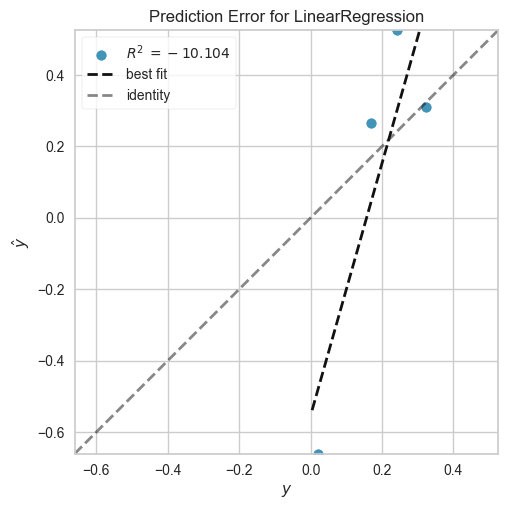

In [24]:
s_exact.plot_model(best_exact, plot="error")

## Trotter (Simulation, Noise free)

In [9]:
s_sim = RegressionExperiment()
s_sim.setup(
    data=data_sim_df,
    target="expected_value",
    ignore_features="sample_id",
    train_size=0.5,
    session_id=42,
)
best_sim = s_sim.compare_models(turbo=True)

,Description,Value
0,Session id,42
1,Target,expected_value
2,Target type,Regression
3,Original data shape,"(20, 11)"
4,Transformed data shape,"(20, 10)"
5,Transformed train set shape,"(10, 10)"
6,Transformed test set shape,"(10, 10)"
7,Ignore features,9
8,Numeric features,9
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lr,Linear Regression,1.1637,3.2254,1.1637,nan,0.5158,11.5258,0.0040
lasso,Lasso Regression,0.2911,0.1304,0.2911,nan,0.2201,4.8197,0.0030
ridge,Ridge Regression,0.1037,0.0181,0.1037,nan,0.0699,1.2514,0.0040
en,Elastic Net,0.2911,0.1304,0.2911,nan,0.2201,4.8197,0.0040
lar,Least Angle Regression,4.3054,55.1942,4.3054,nan,1.0301,41.3327,0.0040
llar,Lasso Least Angle Regression,0.2911,0.1304,0.2911,nan,0.2201,4.8197,0.0040
omp,Orthogonal Matching Pursuit,0.0869,0.0108,0.0869,nan,0.0646,1.3221,0.0030
br,Bayesian Ridge,0.1053,0.0156,0.1053,nan,0.0764,1.8147,0.0030
par,Passive Aggressive Regressor,0.0926,0.0139,0.0926,nan,0.0670,1.8019,0.0050
huber,Huber Regressor,0.2667,0.0902,0.2667,nan,0.1519,3.9751,0.0040


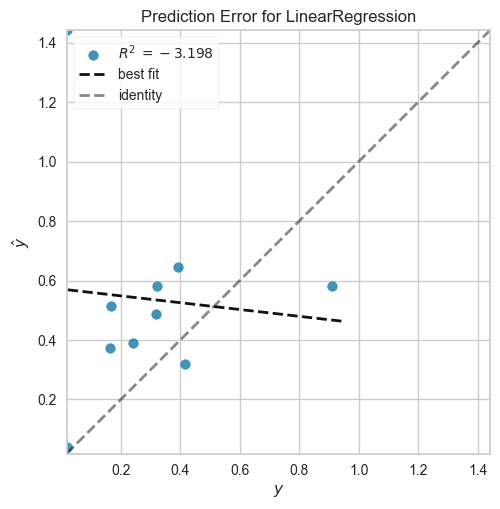

In [10]:
s_sim.plot_model(best_sim, plot="error")

## Trotter (Simulation, Noisy)

In [11]:
s_sim_noisy = RegressionExperiment()
s_sim_noisy.setup(
    data=data_sim_noisy_df,
    target="expected_value",
    ignore_features="sample_id",
    train_size=0.5,
    session_id=42,
)
best_sim_noisy = s_sim_noisy.compare_models(turbo=True)

,Description,Value
0,Session id,42
1,Target,expected_value
2,Target type,Regression
3,Original data shape,"(20, 11)"
4,Transformed data shape,"(20, 10)"
5,Transformed train set shape,"(10, 10)"
6,Transformed test set shape,"(10, 10)"
7,Ignore features,9
8,Numeric features,9
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lr,Linear Regression,0.3756,0.1956,0.3756,nan,0.2212,5.1442,0.0040
lasso,Lasso Regression,0.2911,0.1304,0.2911,nan,0.2201,4.8197,0.0120
ridge,Ridge Regression,0.1047,0.0189,0.1047,nan,0.0697,1.0765,0.0040
en,Elastic Net,0.2911,0.1304,0.2911,nan,0.2201,4.8197,0.0030
lar,Least Angle Regression,185357.1035,182426096966.2000,185357.1035,nan,10.0329,2212584.2093,0.0040
llar,Lasso Least Angle Regression,0.2911,0.1304,0.2911,nan,0.2201,4.8197,0.0040
omp,Orthogonal Matching Pursuit,0.0882,0.0110,0.0882,nan,0.0642,1.2843,0.0030
br,Bayesian Ridge,0.1085,0.0158,0.1085,nan,0.0769,1.7928,0.0030
par,Passive Aggressive Regressor,0.0961,0.0138,0.0961,nan,0.0643,1.8846,0.0040
huber,Huber Regressor,0.3373,0.1675,0.3373,nan,0.1879,4.3073,0.0050


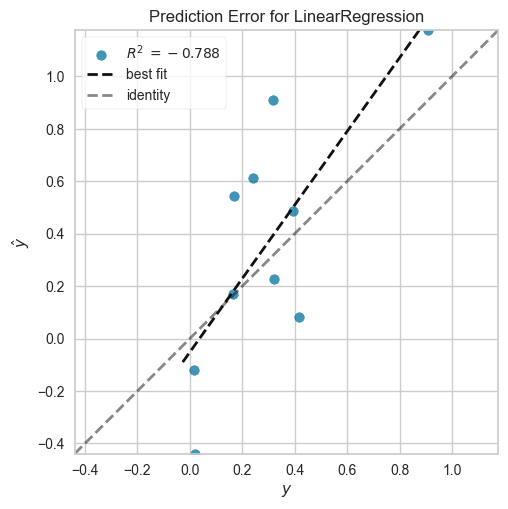

In [12]:
s_sim_noisy.plot_model(best_sim_noisy, plot="error")

## Trotter (QPU, no mitigation)

In [13]:
s_nmit = RegressionExperiment()
s_nmit.setup(
    data=data_nmit_df,
    target="expected_value",
    ignore_features="sample_id",
    train_size=0.8,
)
best_nmit = s_nmit.compare_models(turbo=True)

,Description,Value
0,Session id,412
1,Target,expected_value
2,Target type,Regression
3,Original data shape,"(20, 11)"
4,Transformed data shape,"(20, 10)"
5,Transformed train set shape,"(16, 10)"
6,Transformed test set shape,"(4, 10)"
7,Ignore features,9
8,Numeric features,9
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lr,Linear Regression,0.1713,0.0433,0.1849,nan,0.1284,3.0614,0.0040
lasso,Lasso Regression,0.2434,0.0976,0.2742,nan,0.2056,5.3766,0.0030
ridge,Ridge Regression,0.1041,0.0168,0.1137,nan,0.0739,1.6470,0.0030
en,Elastic Net,0.2434,0.0976,0.2742,nan,0.2056,5.3766,0.0030
lar,Least Angle Regression,0.5788,0.9734,0.5911,nan,0.2718,5.7578,0.0030
llar,Lasso Least Angle Regression,0.2434,0.0976,0.2742,nan,0.2056,5.3766,0.0040
omp,Orthogonal Matching Pursuit,0.0996,0.0143,0.1038,nan,0.0687,1.9740,0.0030
br,Bayesian Ridge,0.1057,0.0167,0.1117,nan,0.0750,2.0435,0.0030
par,Passive Aggressive Regressor,0.0958,0.0169,0.1049,nan,0.0684,1.3734,0.0110
huber,Huber Regressor,0.2041,0.0526,0.2098,nan,0.1364,3.6394,0.0050


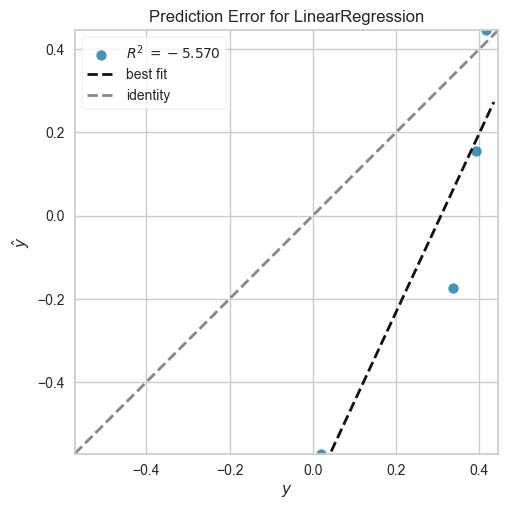

In [14]:
s_nmit.plot_model(best_nmit, plot="error")

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.2284,0.0779,0.2791,0.4312,0.1665,0.4242
1,0.0694,0.0085,0.0919,-1.5711,0.0732,0.2227
2,0.2044,0.0709,0.2663,0.5607,0.1561,0.3647
3,0.0406,0.0017,0.0411,-0.3849,0.0370,0.3847
4,0.1650,0.0404,0.2010,-2.2546,0.1477,1.9761
5,0.2185,0.0744,0.2728,0.4281,0.1629,0.3784
6,0.0283,0.0008,0.0283,nan,0.0270,0.8654
7,0.0583,0.0034,0.0583,nan,0.0557,3.3328
8,0.0470,0.0022,0.0470,nan,0.0451,2.7362


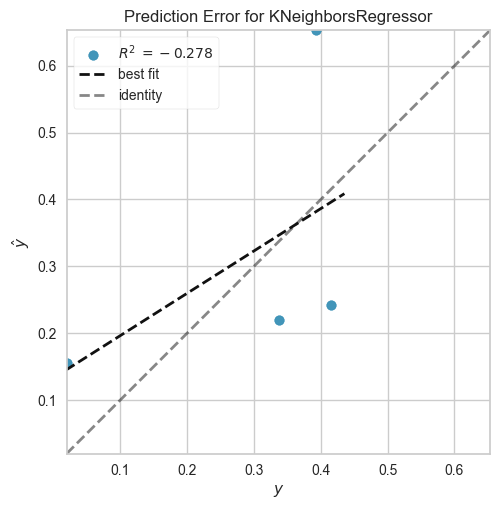

In [15]:
manual_model_nmit = s_nmit.create_model("knn")
s_nmit.plot_model(manual_model_nmit, plot="error")

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0872,0.0100,0.1002,0.9267,0.0797,0.4398
1,0.1375,0.0267,0.1635,-7.1293,0.1242,0.6187
2,0.3438,0.1384,0.3720,0.1431,0.2076,1.2178
3,0.1699,0.0457,0.2138,-36.4455,0.1663,1.2859
4,0.2439,0.0656,0.2561,-4.2843,0.1839,5.2700
5,0.1639,0.0313,0.1769,0.7595,0.1322,0.7392
6,0.1130,0.0128,0.1130,nan,0.0450,3.4523
7,0.0163,0.0003,0.0163,nan,0.0159,0.9309
8,0.2774,0.0769,0.2774,nan,0.2142,16.1553


Fitting 10 folds for each of 2 candidates, totalling 20 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


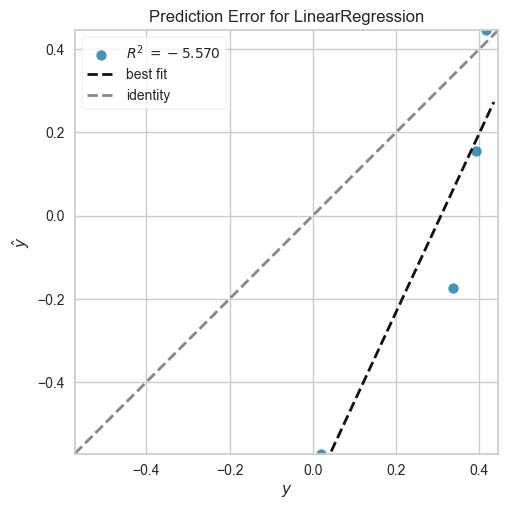

In [16]:
s_nmit.tune_model(best_nmit, optimize="MSE", choose_better=True)
s_nmit.plot_model(best_nmit, plot="error")

## Trotter (QPU, mitigation)

In [17]:
s_mit = RegressionExperiment()
s_mit.setup(
    data=data_mit_df,
    target="expected_value",
    ignore_features="sample_id",
    train_size=0.7,
    session_id=42,
)
best_mit = s_mit.compare_models(turbo=True)

,Description,Value
0,Session id,42
1,Target,expected_value
2,Target type,Regression
3,Original data shape,"(20, 11)"
4,Transformed data shape,"(20, 10)"
5,Transformed train set shape,"(14, 10)"
6,Transformed test set shape,"(6, 10)"
7,Ignore features,9
8,Numeric features,9
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lr,Linear Regression,0.2992,0.1325,0.3146,nan,0.2172,4.1538,0.0040
lasso,Lasso Regression,0.3122,0.1365,0.3234,nan,0.2349,4.5686,0.0030
ridge,Ridge Regression,0.1121,0.0180,0.1182,nan,0.0784,1.0587,0.0030
en,Elastic Net,0.3122,0.1365,0.3234,nan,0.2349,4.5686,0.0030
lar,Least Angle Regression,0.8240,1.9145,0.8914,nan,0.3977,7.0018,0.0030
llar,Lasso Least Angle Regression,0.3122,0.1365,0.3234,nan,0.2349,4.5686,0.0030
omp,Orthogonal Matching Pursuit,0.0927,0.0111,0.0963,nan,0.0655,1.3269,0.0030
br,Bayesian Ridge,0.1145,0.0163,0.1203,nan,0.0834,1.5337,0.0030
par,Passive Aggressive Regressor,0.1078,0.0188,0.1133,nan,0.0719,1.2811,0.0030
huber,Huber Regressor,0.2060,0.0485,0.2128,nan,0.1496,2.6664,0.0050


In [18]:
holdout_pred_mit = s_mit.predict_model(best_mit)
display(holdout_pred_mit)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,0.1190,0.0224,0.1497,-0.8390,0.1208,2.2802


,f_0 Re,f_1 Re,f_1 Im,f_2 Re,f_2 Im,f_3 Re,f_3 Im,f_4 Re,f_4 Im,expected_value,prediction_label
0,0.977539,0.675373,-0.461717,0.211079,-0.562331,-0.055408,-0.295551,0.072809,0.093250,0.019342,0.235783
17,0.982910,0.851413,-0.003989,0.769275,0.036555,0.580047,0.071033,0.342158,0.060244,0.322856,0.384680
15,0.974854,0.827268,-0.157749,0.669568,-0.241860,0.369754,-0.170929,0.049208,-0.017332,0.168328,0.203186
1,0.978271,0.865917,0.167422,0.697617,0.250633,0.454345,0.297072,0.213217,0.242870,0.240820,0.478701
8,0.976807,0.862227,-0.105732,0.670833,-0.101773,0.402173,-0.075471,0.115751,-0.023993,0.162962,0.324032
5,0.981689,0.872747,-0.255196,0.772212,-0.422205,0.666526,-0.534592,0.458052,-0.625221,0.017484,0.019524


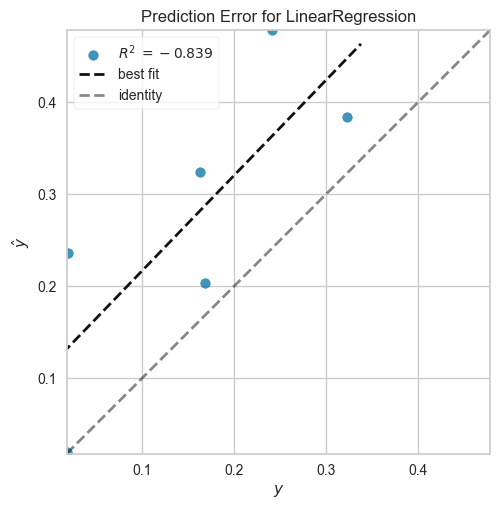

In [19]:
s_mit.plot_model(best_mit, plot="error")

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.2611,0.0898,0.2997,-0.4695,0.1786,0.3615
1,0.1292,0.0187,0.1369,-12.1809,0.0942,0.3547
2,0.2359,0.0737,0.2714,-1366.3704,0.1881,8.4748
3,0.1787,0.0362,0.1902,-2.9534,0.1572,0.7490
4,0.0863,0.0074,0.0863,nan,0.0444,0.0956
5,0.1655,0.0274,0.1655,nan,0.1213,9.6421
6,0.1555,0.0242,0.1555,nan,0.1316,1.4648
7,0.2225,0.0495,0.2225,nan,0.1253,0.2501
8,0.1499,0.0225,0.1499,nan,0.1304,1.9617


Fitting 10 folds for each of 2 candidates, totalling 20 fits


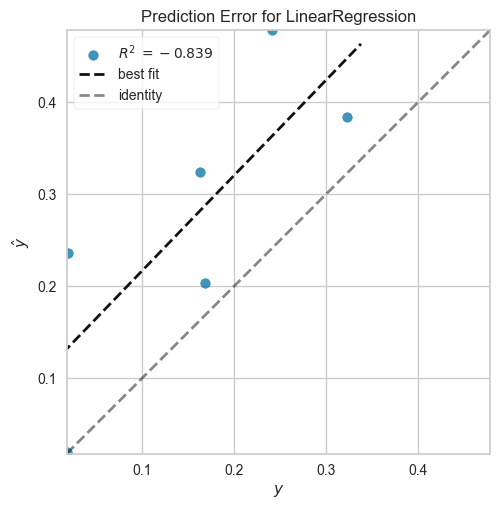

In [20]:
s_mit.tune_model(best_mit, optimize="MSE", choose_better=True)
s_mit.plot_model(best_mit, plot="error")

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0506,0.0032,0.0565,0.9478,0.0313,0.0723
1,0.2326,0.0647,0.2544,-44.5072,0.1693,0.6318
2,0.0725,0.0053,0.0726,-96.7787,0.0683,3.0685
3,0.0794,0.0069,0.0833,0.2415,0.0670,0.3400
4,0.2316,0.0536,0.2316,nan,0.1297,0.2564
5,0.0236,0.0006,0.0236,nan,0.0230,1.3768
6,0.0227,0.0005,0.0227,nan,0.0208,0.2142
7,0.3188,0.1016,0.3188,nan,0.1848,0.3583
8,0.0968,0.0094,0.0968,nan,0.0862,1.2675


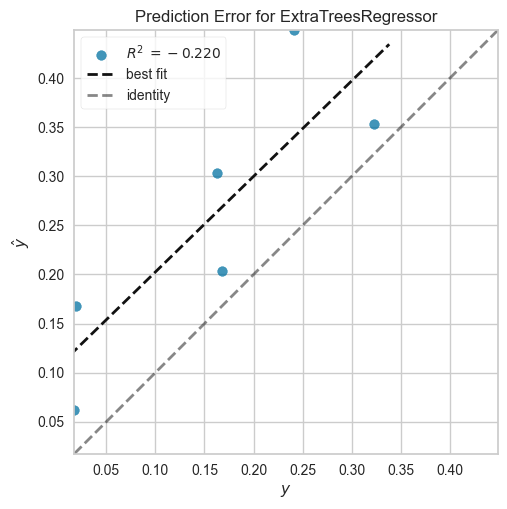

In [21]:
manual_model_mit = s_mit.create_model("et")
s_mit.plot_model(manual_model_mit, plot="error")

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.3698,0.1978,0.4448,-2.2368,0.2832,0.4865
1,0.0377,0.0017,0.0413,-0.2004,0.0304,0.1024
2,0.3664,0.1343,0.3665,-2491.3827,0.3056,15.8465
3,0.1148,0.0223,0.1495,-1.4411,0.1196,0.7478
4,0.6135,0.3764,0.6135,nan,0.3892,0.6794
5,0.3455,0.1194,0.3455,nan,0.2925,20.1269
6,0.2502,0.0626,0.2502,nan,0.2039,2.3561
7,0.5921,0.3505,0.5921,nan,0.3759,0.6655
8,0.2851,0.0813,0.2851,nan,0.2350,3.7314


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


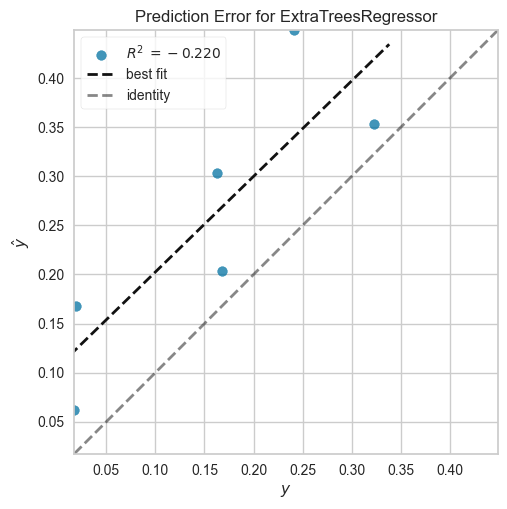

In [22]:
tuned_manual_model_mit = s_mit.tune_model(manual_model_mit, optimize="R2")
s_mit.plot_model(tuned_manual_model_mit, plot="error")